In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os

import random

from skimage.io import imread, imshow
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
import cv2

from pathlib import Path
import nibabel as nib
from sklearn import preprocessing


import torchvision.models as models
from torchvision import datasets, models, transforms

# from torchsummary import sumarry

In [2]:
#https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
#         print(x.shape)
#         x = x.view(x.size(0), -1)
#         print('flat: ', x.shape)
        x = self.classifier(x)
#         print('before ret ', x.shape)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [3]:
def vgg19(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration "E")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        state_dict = torch.load('vgg19-dcbb9e9d.pth')
        model.load_state_dict(state_dict)
#         model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model

In [4]:
model = vgg19(pretrained=True)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [5]:
print(model.features[-3])

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [4]:
def accuracy(out, labels):
#     print(out.data)
    total = 0.0
    _,predicted = torch.max(out, 1)
#     print(predicted)
    labels_ = torch.argmax(labels.data)
#     print(labels.data)

    total += (predicted == labels_).sum().item()
#     print(total, len(predicted))
    return total/len(predicted)

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)



In [7]:
for param in model.parameters():
    param.requires_grad = False


model.features[-5] = nn.Conv2d(512,512,3, padding=1)
model.features[-3] = nn.Conv2d(512,2,3, padding=1)
    
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1),Flatten(),
                                nn.LogSoftmax()
                                )

In [6]:
data_dir = "hymenoptera_data/"

In [27]:
num_classes = 2
batch_size = 1
num_epochs = 20
# feature_extract = True

In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
input_size=224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [11]:
criterion = nn.CrossEntropyLoss()
lr =.00001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [12]:
import copy

In [13]:

dataloaders = dataloaders_dict

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []
minLoss = 99999
maxValacc = -99999
for epoch in range(200):
    print('EPOCH: ',epoch+1)
#     train_losses = []
#     val_losses = []    
    train_acc = []
    val_acc = []
    
    running_loss = 0.0
    
    model.train()
    count = 0
    for images, labels in dataloaders['train']:        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
#         print(images.shape)
        outputs = model(images) 
#         print(outputs)
#         print(labels)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        
        train_acc.append(accuracy(outputs, labels))
        
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        count +=1
    
    print('Training loss:.......', running_loss/count)
#     print('Training accuracy:...', np.mean(train_acc))
    mean_train_losses.append(running_loss/count)
        
    model.eval()
    count = 0
    val_running_loss = 0.0
    for images, labels in dataloaders['val']:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_acc.append(accuracy(outputs, labels))
        val_running_loss += loss.item()
        count +=1

    mean_val_loss = val_running_loss/count
    print('Validation loss:.....', mean_val_loss)
    
    print('Training accuracy:...', np.mean(train_acc))
    print('Validation accuracy..', np.mean(val_acc))
    
    mean_val_losses.append(mean_val_loss)
    
    mean_train_acc.append(np.mean(train_acc))
    
    val_acc_ = np.mean(val_acc)
    mean_val_acc.append(val_acc_)
    
   
    if mean_val_loss < minLoss:
        torch.save(model.state_dict(), 'bees.pth' )
        print(f'NEW BEST: {mean_val_loss} ........old best:{minLoss}')
        minLoss = mean_val_loss
        print('')
        
    if val_acc_ > maxValacc:
        torch.save(model.state_dict(), 'acc_bees.pth' )
        print(f'NEW BEST: {val_acc_} ........old best:{maxValacc}')
        maxValacc = val_acc_
    
    
    print('')
    
#     else:
#         print(f'Val Loss did not improve from {minLoss}')

EPOCH:  1


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training loss:....... 0.6717482209205627
Validation loss:..... 0.6409486929575602
Training accuracy:... 0.0
Validation accuracy.. 0.315625
NEW BEST: 0.6409486929575602 ........old best:99999

NEW BEST: 0.315625 ........old best:-99999

EPOCH:  2
Training loss:....... 0.625222772359848
Validation loss:..... 0.5858175357182821
Training accuracy:... 0.19340093085106383
Validation accuracy.. 0.0
NEW BEST: 0.5858175357182821 ........old best:0.6409486929575602


EPOCH:  3
Training loss:....... 0.5945878773927689
Validation loss:..... 0.55496217807134
Training accuracy:... 0.07421875
Validation accuracy.. 0.15104166666666666
NEW BEST: 0.55496217807134 ........old best:0.5858175357182821


EPOCH:  4
Training loss:....... 0.558459609746933
Validation loss:..... 0.5365650057792664
Training accuracy:... 0.18359375
Validation accuracy.. 0.28125
NEW BEST: 0.5365650057792664 ........old best:0.55496217807134


EPOCH:  5
Training loss:....... 0.5282295644283295
Validation loss:..... 0.48649013042449

Training loss:....... 0.21040694415569305
Validation loss:..... 0.2869132657845815
Training accuracy:... 0.1276595744680851
Validation accuracy.. 0.0

EPOCH:  44
Training loss:....... 0.1733326818794012
Validation loss:..... 0.2780889521042506
Training accuracy:... 0.2487533244680851
Validation accuracy.. 0.48583333333333334

EPOCH:  45
Training loss:....... 0.1815076433122158
Validation loss:..... 0.2344162861506144
Training accuracy:... 0.22074468085106383
Validation accuracy.. 0.4533333333333333
NEW BEST: 0.2344162861506144 ........old best:0.23486403624216715


EPOCH:  46
Training loss:....... 0.16506190598011017
Validation loss:..... 0.24416556457678476
Training accuracy:... 0.265625
Validation accuracy.. 0.14666666666666667

EPOCH:  47
Training loss:....... 0.17864465527236462
Validation loss:..... 0.21871104836463928
Training accuracy:... 0.2853224734042553
Validation accuracy.. 0.331875
NEW BEST: 0.21871104836463928 ........old best:0.2344162861506144


EPOCH:  48
Training loss

Training loss:....... 0.09933486767113209
Validation loss:..... 0.2655200660228729
Training accuracy:... 0.2734375
Validation accuracy.. 0.13333333333333333

EPOCH:  92
Training loss:....... 0.10504001937806606
Validation loss:..... 0.26575128237406415
Training accuracy:... 0.13671875
Validation accuracy.. 0.17333333333333334

EPOCH:  93
Training loss:....... 0.12557159923017025
Validation loss:..... 0.2968829969565074
Training accuracy:... 0.359375
Validation accuracy.. 0.431875

EPOCH:  94
Training loss:....... 0.11916221864521503
Validation loss:..... 0.23096868892510733
Training accuracy:... 0.0
Validation accuracy.. 0.44812499999999994

EPOCH:  95
Training loss:....... 0.10651395283639431
Validation loss:..... 0.2400913362701734
Training accuracy:... 0.09574468085106383
Validation accuracy.. 0.464375

EPOCH:  96
Training loss:....... 0.10939741507172585
Validation loss:..... 0.2760264178117116
Training accuracy:... 0.36328125
Validation accuracy.. 0.3177083333333333

EPOCH:  97
Tr

Training loss:....... 0.057929838076233864
Validation loss:..... 0.39787545303503674
Training accuracy:... 0.1276595744680851
Validation accuracy.. 0.31916666666666665

EPOCH:  141
Training loss:....... 0.07180885132402182
Validation loss:..... 0.31567263541122276
Training accuracy:... 0.24734042553191488
Validation accuracy.. 0.3272916666666667

EPOCH:  142
Training loss:....... 0.0861170431599021
Validation loss:..... 0.3703506787618001
Training accuracy:... 0.25
Validation accuracy.. 0.28729166666666667

EPOCH:  143
Training loss:....... 0.054737044498324394
Validation loss:..... 0.29579420387744904
Training accuracy:... 0.23420877659574468
Validation accuracy.. 0.0

EPOCH:  144
Training loss:....... 0.06292596738785505
Validation loss:..... 0.31278831760088605
Training accuracy:... 0.125
Validation accuracy.. 0.14583333333333334

EPOCH:  145
Training loss:....... 0.10753010399639606
Validation loss:..... 0.36381035049756366
Training accuracy:... 0.0
Validation accuracy.. 0.464375



Training loss:....... 0.06692945118993521
Validation loss:..... 0.24922093624869981
Training accuracy:... 0.25232712765957444
Validation accuracy.. 0.16145833333333334

EPOCH:  190
Training loss:....... 0.05901163909584284
Validation loss:..... 0.3297977348168691
Training accuracy:... 0.09375
Validation accuracy.. 0.480625

EPOCH:  191
Training loss:....... 0.07004586234688759
Validation loss:..... 0.29656123618284863
Training accuracy:... 0.125
Validation accuracy.. 0.0

EPOCH:  192
Training loss:....... 0.06464988086372614
Validation loss:..... 0.2522482890635729
Training accuracy:... 0.26953125
Validation accuracy.. 0.15625

EPOCH:  193
Training loss:....... 0.04858863726258278
Validation loss:..... 0.28195791443188983
Training accuracy:... 0.3606216755319149
Validation accuracy.. 0.11458333333333333

EPOCH:  194
Training loss:....... 0.05346962623298168
Validation loss:..... 0.31622229516506195
Training accuracy:... 0.0
Validation accuracy.. 0.0

EPOCH:  195
Training loss:....... 0

In [14]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [9]:
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output#.cpu().data().numpy()
    def remove(self): self.hook.remove()

In [10]:
model1 = vgg19()
model1.features[-5] = nn.Conv2d(512,512,3, padding=1)
model1.features[-3] = nn.Conv2d(512,2,3, padding=1)    
model1.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1),Flatten(),
                                nn.LogSoftmax()
                                )


In [11]:
state_dict = torch.load('bees.pth')
model1.load_state_dict(state_dict)
model1.eval()
model1.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [47]:
sf = SaveFeatures(model1.features[-3])

In [30]:
dat = dataloaders_dict['train']

In [32]:
im, lab = next(iter(dat))
print(lab)

tensor([0])


In [46]:
count = 0
tot = 0
for  im, lab in dat:
    im = Variable(im.cuda())
    lab = Variable(lab.cuda())
    outputs = F.softmax(model1(im))
#     print(outputs)
#     print(lab)
    _,pred = torch.max(outputs,1)
    
    if pred == lab.data:
#         print(pred, lab.data)
        tot +=1
#     else: print('wrong')
    count +=1
#     total += (predicted == labels_).sum().item()
#     print(total, len(predicted))
#     print(out)

print('acc: ', tot/count)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


acc:  0.9497907949790795


In [34]:
F.softmax(outputs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.9359, 0.0641]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [204]:
sf = SaveFeatures(model1.features[-3])
im, lab = next(iter(dat))
img = im
im = Variable(im.cuda())
lab = Variable(lab.cuda())
outputs = F.softmax(model1(im))
_,pred = torch.max(outputs,1)
    
if pred == lab.data:
    print('correct')  
    print('label', lab.data)
else: print('wrong')
  

correct
label tensor([1], device='cuda:0')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


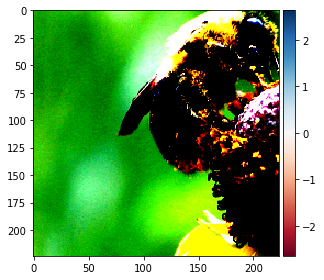

In [130]:
imshow(img)

In [131]:
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]

In [132]:
arr1.shape

(2, 14, 14)

In [133]:
ans = np.dot(np.rollaxis(arr1,0,3), [0,1])

In [134]:
ans.shape

(14, 14)

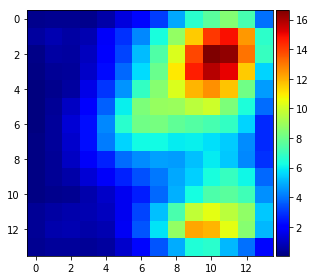

In [136]:
imshow(ans, cmap='jet')

In [139]:
from skimage.transform import resize
a = resize(ans, (224,224))

/opt/conda/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


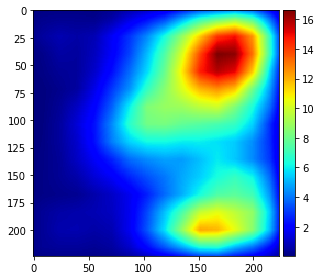

In [141]:
imshow(a,cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


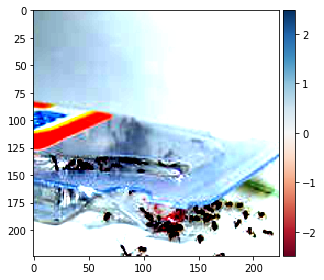

In [159]:
imshow(img)

/opt/conda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


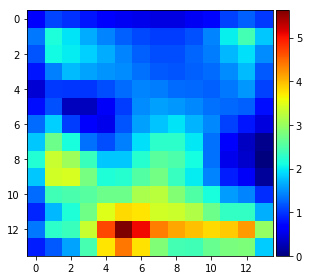

In [160]:
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]
ans = np.dot(np.rollaxis(arr1,0,3), [1,0])
imshow(ans, cmap='jet')

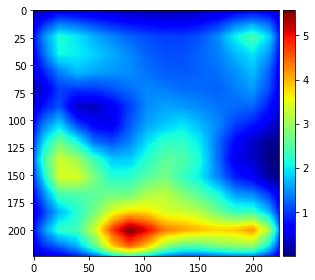

In [163]:
a = resize(ans, (224,224))
imshow(a,cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

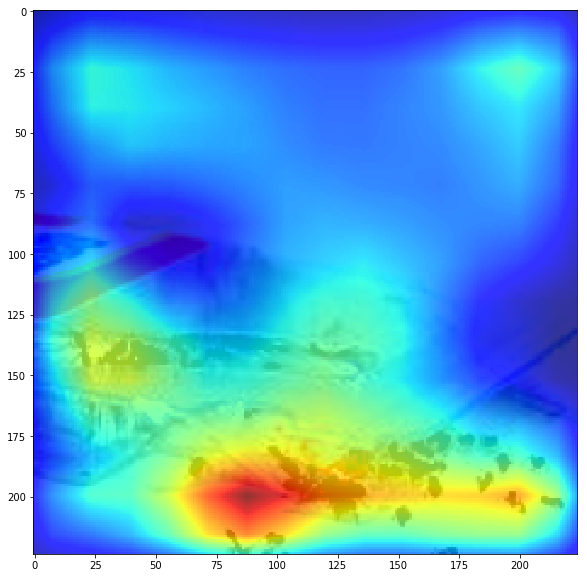

In [168]:
plt.figure()
plt.subplots(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.imshow(a, alpha=.8, cmap='jet')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


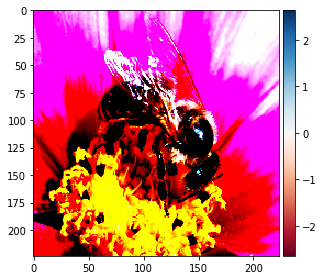

In [210]:
imshow(img)

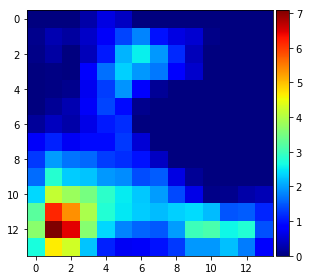

In [214]:
other = np.dot(np.rollaxis(arr1,0,3), [1,0])
imshow(other, cmap='jet')

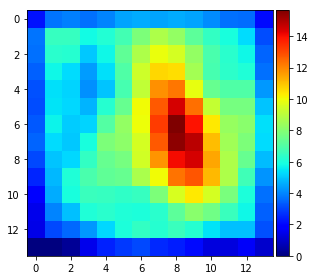

In [216]:
ans = np.dot(np.rollaxis(arr1,0,3), [0,1])
imshow(ans, cmap='jet')